Import libraries

In [88]:
# No special installs needed, just import
import pandas as pd
import numpy as np
import re
from google.colab import files


upload files

In [89]:
# Upload both normalized Excel files
uploaded = files.upload()

# Load them
gt_filename = [f for f in uploaded if "Ground_Truth" in f][0]
pred_filename = [f for f in uploaded if "Predictions" in f][0]

df_gt = pd.read_excel(gt_filename)
df_pred = pd.read_excel(pred_filename)


Saving Ground_Truth_v3.xlsx to Ground_Truth_v3 (2).xlsx
Saving Predictions.xlsx to Predictions (8).xlsx


Merge files

In [90]:
# Merge on image ID
df_merged = pd.merge(df_gt, df_pred, left_on="image_ID", right_on="Image_ID")
df_merged.drop(columns=["Image_ID"], inplace=True)

# Convert stringified sets to real Python sets
def to_set(val):
    if isinstance(val, str):
        return set(eval(val))
    return val

df_merged["Ground_Truth_Set"] = df_merged["Ground_Truth_Set"].apply(to_set)
df_merged["Predicted_Set"] = df_merged["Predicted_Set"].apply(to_set)


Precision, recall and F1 score

In [91]:
def compute_metrics(row):
    gt = row["Ground_Truth_Set"]
    pred = row["Predicted_Set"]
    tp = len(gt & pred)
    fp = len(pred - gt)
    fn = len(gt - pred)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return pd.Series([precision, recall, f1])

df_merged[["Precision", "Recall", "F1_Score"]] = df_merged.apply(compute_metrics, axis=1)
df_merged.head()


,image_ID,Difficulty_level,Dish Name_x,Ground_Truth_Set,Dish Name_y,Predicted_Set,Precision,Recall,F1_Score
0,1,Easy,Prawns and garin poke bowls,"{avocado, lime, chilli, sesam seeds, radishes,...",Shrimp Grain Bowl,"{sesame, avocado, grains, shrimp, mango, onion...",0.428571,0.375000,0.400000
1,2,Medium,"Chicken, mango & noodle salad","{chillies, limes, mangoes, sesame oil, honey, ...",Mango Chicken Vermicelli,"{red chili, cilantro, rice, chicken, lime, mango}",0.166667,0.125000,0.142857
2,3,Medium,Beef sandwish with pink pickled onions,"{avocado sauce, red onion, leftover beef, demi...",Steak Baguette Sandwich,"{kale, baguette, beef, sauce, beans, onion}",0.166667,0.125000,0.142857
3,4,Medium,Shake-it-up chopped salad,"{olive oil, garlic clove, lemon, black olives,...",Italian Antipasto Salad,"{lettuce, cucumber, salami, cheese, dressing, ...",0.500000,0.235294,0.320000
4,5,Easy,Chilled-green-soup-with-feta,"{baby spimach, seeds, olive oil, cucumber, avo...",Spinach Feta Soup,"{cheese, spinach, olive oil, spices, mixed seeds}",0.200000,0.083333,0.117647


Export results

In [92]:
# Save to Excel
output_file = "Evaluation_Results.xlsx"
df_merged.to_excel(output_file, index=False)

# Download the file
files.download(output_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Visualization of results**

Show the overall performance distribution across all images. Histogram of F1 score

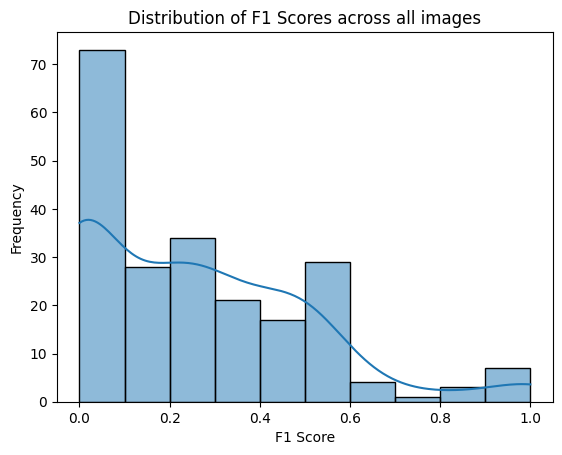

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_merged["F1_Score"], bins=10, kde=True)
plt.title("Distribution of F1 Scores across all images")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.show()


Most images have low F1-Scores (clustered near 0).\\

Fewer images achieve high F1-Scores, meaning full or near-perfect recognition is rare.\\

The kde curve (blue line) helps visualize the density of scores — showing a sharp drop after 0.2-0.3.

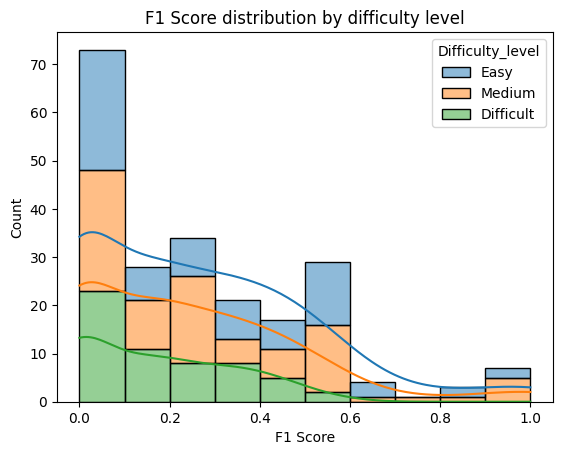

In [94]:
sns.histplot(data=df_merged, x="F1_Score", hue="Difficulty_level", bins=10, kde=True, multiple="stack")

plt.title("F1 Score distribution by difficulty level")
plt.xlabel("F1 Score")
plt.ylabel("Count")


plt.show()


Most "Difficult" cases are in the lowest F1 range.
"Easy" cases show the broadest spread, with some achieving high scores.


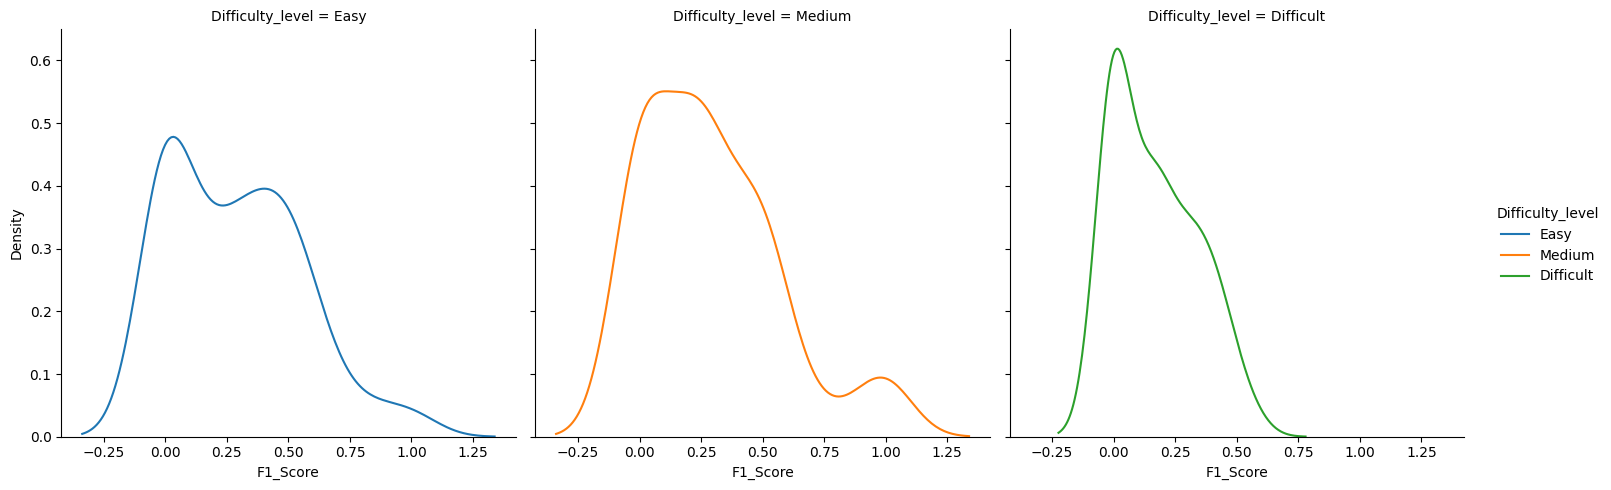

In [95]:
sns.displot(data=df_merged, x="F1_Score", hue="Difficulty_level", kind="kde", col="Difficulty_level")


Each difficulty level has a distinct F1 distribution.
"Difficult" images cluster around very low F1 scores, while "Easy" and "Medium" have a broader distribution.


**how performance varies across easy, medium, and difficult images ?**



Highlight which component (precision or recall ) drops with difficulty ?

<ipython-input-96-2b8a118d1bcb>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Difficulty_level", y="F1_Score", data=df_merged, palette=custom_palette, ax=ax[0])
<ipython-input-96-2b8a118d1bcb>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Difficulty_level", y="Precision", data=df_merged, palette=custom_palette, ax=ax[1])
<ipython-input-96-2b8a118d1bcb>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Difficulty_level", y="Recall", data=df_merged, palette=custom_palette, ax=ax[2])


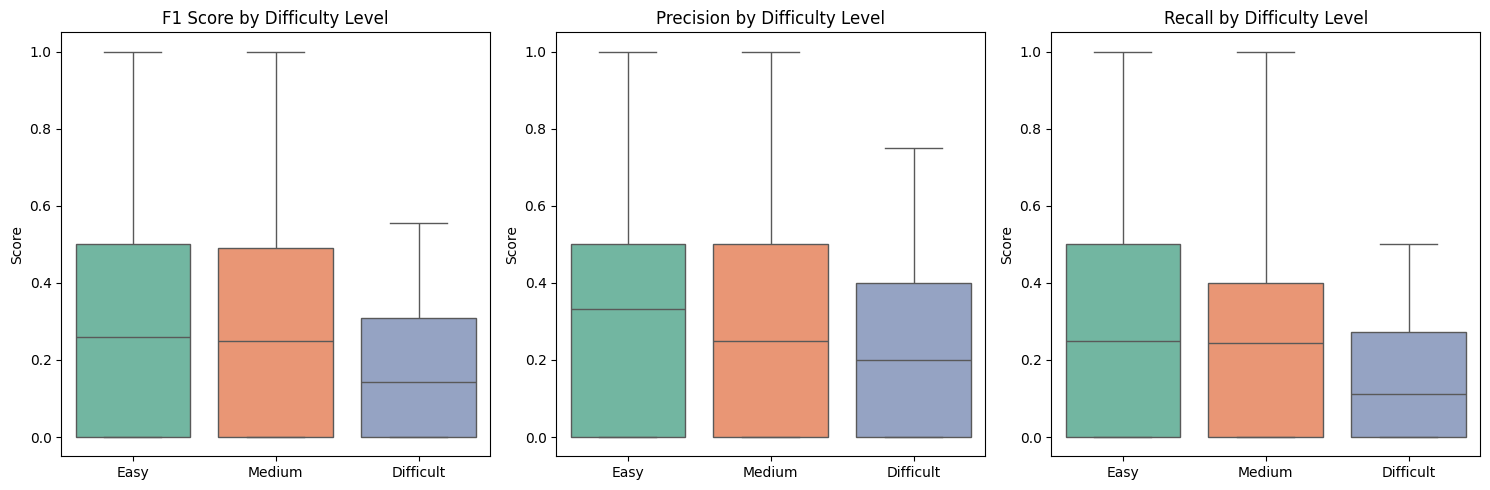

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a consistent color palette for difficulty levels
custom_palette = {
    "Easy": "#66c2a5",       # light green
    "Medium": "#fc8d62",     # orange
    "Difficult": "#8da0cb"   # light blue
}

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# F1 Score boxplot
sns.boxplot(x="Difficulty_level", y="F1_Score", data=df_merged, palette=custom_palette, ax=ax[0])
ax[0].set_title("F1 Score by Difficulty Level")

# Precision boxplot
sns.boxplot(x="Difficulty_level", y="Precision", data=df_merged, palette=custom_palette, ax=ax[1])
ax[1].set_title("Precision by Difficulty Level")

# Recall boxplot
sns.boxplot(x="Difficulty_level", y="Recall", data=df_merged, palette=custom_palette, ax=ax[2])
ax[2].set_title("Recall by Difficulty Level")

# Improve layout
for a in ax:
    a.set_xlabel("")
    a.set_ylabel("Score")
plt.tight_layout()
plt.show()



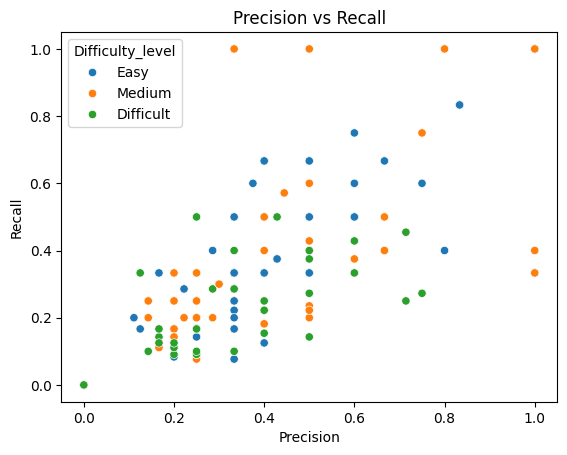

In [97]:
sns.scatterplot(x="Precision", y="Recall", hue="Difficulty_level", data=df_merged)
plt.title("Precision vs Recall")
plt.show()


# ANOVA test on F1 scores

before runing the ANOVA test, i need to check the third assumption of ANOVA. For this purpose, i will run the levene test, and if p >= 0.05 I will proceed with ANOVA. Else, i will consider krushal-wallis test.

In [98]:
# 1. Levene's Test
stat, p = levene(easy_f1, medium_f1, difficult_f1)
print(f"Levene’s p = {p:.4f}")
if p < 0.05:
    print("Variances are not equal: consider Kruskal-Wallis instead.")
else:
    print("Variances are equal:  safe to proceed with ANOVA.")



Levene’s p = 0.0045
Variances are not equal: consider Kruskal-Wallis instead.


Since p < 0.05, the assumption of equal variances is violated, meaning ANOVA is not valid in this case.

 now, we can use  Kruskal-Wallis H-test, which is a non-parametric alternative to ANOVA. It does not assume normality or equal variances and works perfectly for comparing medians across groups.

# Krushal Wallis test



In [99]:
from scipy.stats import kruskal

# Run Kruskal-Wallis Test
stat, p = kruskal(easy_f1, medium_f1, difficult_f1)

print("************* Kruskal-Wallis test results *************")
print(f"Test statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

# Interpret the result
if p < 0.05:
    print("Significant: at least one group's median F1 score differs.")
else:
    print("Not significant: no difference detected between group medians.")


************* Kruskal-Wallis test results *************
Test statistic: 8.0845
p-value: 0.0176
Significant: at least one group's median F1 score differs.


clc: The Kruskal-Wallis test revealed a statistically significant difference in ChatGPT's F1 score performance across difficulty levels (H = 8.08, p = 0.0176), suggesting that the model performs differently depending on the complexity of the food image.

Kruskal Wallis test only tell us that a difference exists, the next step is to find out which pairs differ (med vs diff, etc)

# Dunn's test

In [100]:
!pip install scikit-posthocs
import scikit_posthocs as sp
import pandas as pd

# Run Dunn's test on F1 score grouped by Difficulty_level
dunn_result = sp.posthoc_dunn(df_merged, val_col="F1_Score", group_col="Difficulty_level", p_adjust="bonferroni")

# Show the pairwise p-values
print("********** Dunn’s test pairwise comparisons (Bonferroni-adjusted) **********")
print(dunn_result)


********** Dunn’s test pairwise comparisons (Bonferroni-adjusted) **********
           Difficult      Easy    Medium
Difficult   1.000000  0.040731  0.029167
Easy        0.040731  1.000000  1.000000
Medium      0.029167  1.000000  1.000000


We conclude:\\

Easy vs Diff : significant (p = 0.040731)
Diff vs Medium: significant (p = 0.029267)
Easy vs Nedium : Non-significant (p= 1)

Post hoc analysis using Dunn’s test with Bonferroni correction revealed statistically significant differences in F1-Score performance between the 'Difficult' group and both the 'Easy' (p = 0.0407) and 'Medium' (p = 0.0292) groups. No significant difference was observed between the 'Easy' and 'Medium' groups (p = 1.0000). These results suggest that image difficulty has a measurable impact on ChatGPT's food recognition performance, particularly for the most challenging cases

visualize Dunn test pairwise

Text(0.5, 1.0, "Dunn's test pairwise p-values")

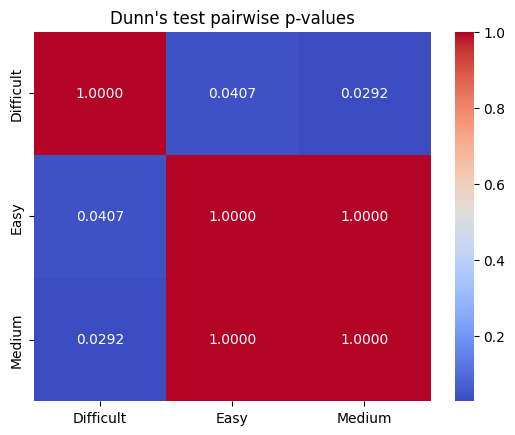

In [101]:
import seaborn as sns
sns.heatmap(dunn_result, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Dunn's test pairwise p-values")


#  Ingredient-level error analysis


Understand which ingredients are most:

 1) Missed by ChatGPT (present in ground truth but not predicted)
 2) Over-predicted by ChatGPT (predicted but not actually present)

This explains why some images have low precision or recall.

Collect all FNs and FPs from all images and count how often each ingredient appears.

Generate Top Error Lists
Create two tables:

Top Missed Ingredients
Top Over-Predicted Ingredients
Sort by frequency.

In [102]:
from collections import Counter

missed_counter = Counter()
overpredicted_counter = Counter()

for _, row in df_merged.iterrows():
    gt = row["Ground_Truth_Set"]
    pred = row["Predicted_Set"]

    missed = gt - pred        # False Negatives
    overpredicted = pred - gt # False Positives

    missed_counter.update(missed)
    overpredicted_counter.update(overpredicted)

# Get top 10 for each
top_missed = missed_counter.most_common(10)
top_overpredicted = overpredicted_counter.most_common(10)

print(" Top missed ingredients:")
for ing, count in top_missed:
    print(f"{ing}: {count}")

print("\n Top over-predicted ingredients:")
for ing, count in top_overpredicted:
    print(f"{ing}: {count}")


 Top missed ingredients:
onion: 28
tomato: 28
salt: 26
pepper: 24
potato: 24
eggs: 22
cheese: 21
olive oil: 18
oil: 15
beans: 15

 Top over-predicted ingredients:
beef: 19
cheese: 19
tomato: 19
sauce: 17
chicken: 16
tomato sauce: 15
onion: 14
egg: 13
bell pepper: 12
meat: 11


Interpretation: Ingredient-level analysis revealed that ChatGPT frequently failed to identify essential but less visible ingredients such as onion, salt, and oil. Additionally, it often over-predicted visually generic or common components such as beef, cheese, and sauce, suggesting a tendency to infer based on context rather than visible evidence alone

# Summary

The statistical analysis revealed that ChatGPT's ability to recognize food ingredients from images significantly varies with image difficulty. Specifically, the Kruskal-Wallis test confirmed a statistically significant difference in F1-Scores between difficulty levels, with Dunn’s post hoc test showing that performance on "Difficult" images is substantially lower than on "Easy" and "Medium" ones. Ingredient-level error analysis further highlighted ChatGPT's tendency to miss visually subtle ingredients (e.g., onion, oil, salt) while over-predicting common elements (e.g., beef, cheese, tomato). These findings suggest that ChatGPT may rely on contextual cues or learned priors rather than purely visual evidence in certain cases.